In [1]:
import torch
import matplotlib.pyplot as plt 

# batch_means = torch.load('long_means_whole_dataset.pt')
# batch_stds = torch.load('long_stds_whole_dataset.pt')
batch_means = torch.load('normalized_long_means_ipsl.pt')
batch_stds = torch.load('normalized_long_stds_ipsl.pt')
lat_coeffs_equi = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])
lat_coeffs_equi =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]
run_name = 'flow_proper_lat_weight_1_300_1_long_rollout'

In [2]:
#need this if using de-normalized values
batch_stds = batch_stds**(1/2)

In [2]:
import numpy as np
import xarray as xr 
from hydra import compose, initialize_config_dir
from omegaconf import OmegaConf
import lightning as pl
import hydra
import torch
import glob
import os 
work = os.environ['WORK']
with initialize_config_dir(config_dir=f"{work}/ipsl_dcpp/ipsl_dcpp/conf"):
    cfg = compose(config_name="config")
device = 'cuda'

pl.seed_everything(cfg.seed)
train = hydra.utils.instantiate(
    cfg.dataloader.dataset,domain='train',debug=True
)
# test_loader = torch.utils.data.DataLoader(train, 
#                                           batch_size=1,
#                                           num_workers=cfg.cluster.cpus,
#                                           shuffle=False) 

/tmp/xpython_3411709/1237045732.py:11: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=f"{work}/ipsl_dcpp/ipsl_dcpp/conf"):
[rank: 0] Seed set to 0
2it [00:02,  1.16s/it]


In [2]:
#load predicted rollout
rollouts = []
for variant in range(0,2):
    lr = torch.load(f'plots/{run_name}/long_rollout_{variant}.pt'
                    ,map_location=torch.device('cpu'))
    rollouts.append(lr)
stacked_rollouts = torch.stack(rollouts)

In [4]:
stacked_rollouts.shape

torch.Size([5, 236, 1, 34, 143, 144])

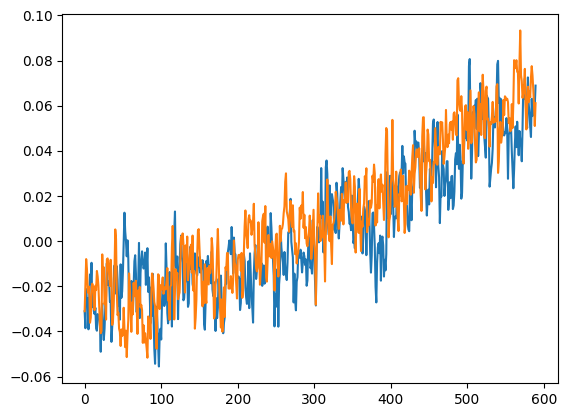

In [4]:
import matplotlib.pyplot as plt 

plt.plot(stacked_rollouts[0,:,0,0].mean(axis=(-1,-2)))
plt.plot(stacked_rollouts[1,:,0,0].mean(axis=(-1,-2)))
# plt.plot(stacked_rollouts[2,:,0,9].mean(axis=(-1,-2)))
# plt.plot(stacked_rollouts[3,:,0,9].mean(axis=(-1,-2)))

In [4]:
for member_index in range(2):
    month_index = 2
    denormalized_surface = []
    for rollout_index in range(590):
        denormed_plev = train.denorm_plev_variables(
            stacked_rollouts[None,member_index,rollout_index,0],month_index,'cpu'
        ) 
        denormed_surface = train.denorm_surface_variables(
            stacked_rollouts[None,member_index,rollout_index,0],month_index,'cpu'
        )
        denormalized_surface.append(torch.concatenate([denormed_surface,denormed_plev],axis=1))
        if(month_index == 11):
            month_index = 0
        else:
            month_index += 1 
    torch.save(torch.stack(denormalized_surface),f'plots/{run_name}/unnormalized_long_rollout_{member_index}')

In [5]:
import matplotlib.pyplot as plt 
import torch 
rollouts = []
for variant in range(0,2):
    lr = torch.load(f'plots/{run_name}/unnormalized_long_rollout_{variant}',map_location=torch.device('cpu'))
    rollouts.append(lr)
stacked_rollouts = torch.stack(rollouts)

In [8]:
stacked_rollouts.shape

torch.Size([5, 236, 1, 34, 143, 144])

In [25]:
lat_coeffs_equi.shape

torch.Size([1, 1, 1, 143, 1])

In [3]:
means = stacked_rollouts[:,:,0,0].mul(lat_coeffs_equi[0]).nanmean(axis=(-1,-2))
stds = means.std(axis=(0))

In [4]:
def generate_monthly_dates(start_year, start_month, num_months):
    dates = []
    current_year = start_year
    current_month = start_month

    for _ in range(num_months):
        # Create a date for the current year and month
        date = datetime.datetime(current_year, current_month, 1)
        dates.append(date)

        # Increment the month
        current_month += 1
        # If month exceeds 12, reset to January and increment the year
        if current_month > 12:
            current_month = 1
            current_year += 1

    return dates
import matplotlib.pyplot as plt
import numpy as np
import datetime

def plot_with_fill(means, stds, bmeans,bstds,color='skyblue', alpha=0.3):
    """
    Plots means with a filled area representing the standard deviations.
    
    Parameters:
    - means: List or array of mean values.
    - stds: List or array of standard deviation values.
    - color: Color of the filled area. Default is 'skyblue'.
    - alpha: Transparency level of the filled area. Default is 0.3.
    """
    x = generate_monthly_dates(1961,1,len(means))
    import matplotlib.dates as mdates
    # myFmt = mdates.DateFormatter('%M-%Y')
    fig,axes=plt.subplots(1,figsize=(24, 6))
    # x = np.arange(len(means))  # X values (e.g., 0, 1, 2, ..., len(means)-1)
    # base = datetime.datetime.today()
    # x = [base - datetime.timedelta(month=1) for x in range(590)]
    # Calculate the upper and lower bounds of the shaded area
    pred_upper_bound = np.array(means) + np.array(stds)
    pred_lower_bound = np.array(means) - np.array(stds)

    pred_upper_bound2 = np.array(means) + np.array(stds)*2
    pred_lower_bound2 = np.array(means) - np.array(stds)*2
    batch_upper_bound = np.array(bmeans) + np.array(bstds)
    batch_lower_bound = np.array(bmeans) - np.array(bstds)
    # axes.xaxis.set_major_formatter(myFmt)

    # Plot the means
    axes.plot(x, means, color='red', label='Predicted Mean')
    axes.plot(x, bmeans, color='blue', label='IPSL Mean')

    # Fill the area between the upper and lower bounds
    plt.fill_between(x, pred_lower_bound, pred_upper_bound, color='red', alpha=alpha, label='±1 Pred Std Dev')
    # plt.fill_between(x, pred_lower_bound2, pred_upper_bound2, color='pink', alpha=alpha, label='±2 Std Dev')

    plt.fill_between(x, batch_upper_bound, batch_lower_bound, color='skyblue', alpha=alpha, label='±1 IPSL Std Dev')
    # plt.fill_between(x, batch_upper_bound, batch_lower_bound, color='lightblue', alpha=alpha, label='±1 Std Dev')
    # years = mdates.YearLocator()   # every year
    # months = mdates.MonthLocator()  # every month
    # years_fmt = mdates.DateFormatter('%d')
    

    dtFmt = mdates.DateFormatter('%Y') # define the formatting

    axes.xaxis.set_major_locator(mdates.MonthLocator(interval=48))
    # axes.xaxis.set_major_formatter(years_fmt)
    # axes.xaxis.set_minor_locator(months)
    # Add labels and legend
    plt.xlabel('Month')
    plt.ylabel('Temperature at Surface')
    plt.title('Mean and Standard Deviation of Temperature At Surface')
    plt.legend()
    # datemin = np.datetime64('1960', 'Y')
    # datemax = np.datetime64('1960', 'Y') + np.timedelta64(59, 'Y')
    # axes.format_xdata = mdates.DateFormatter('%Y-%m')
    
    plt.gca().xaxis.set_major_formatter(dtFmt) 
    # show every 12th tick on x axes
    # plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=0, fontweight='light',  fontsize='x-small',)
    # axes.set_xlim(datemin, datemax)
    # Show the plot
    # plt.show()
    return axes
    # plt.savefig('long_rollout.png')


<Axes: title={'center': 'Mean and Standard Deviation of Temperature At Surface'}, xlabel='Month', ylabel='Temperature at Surface'>

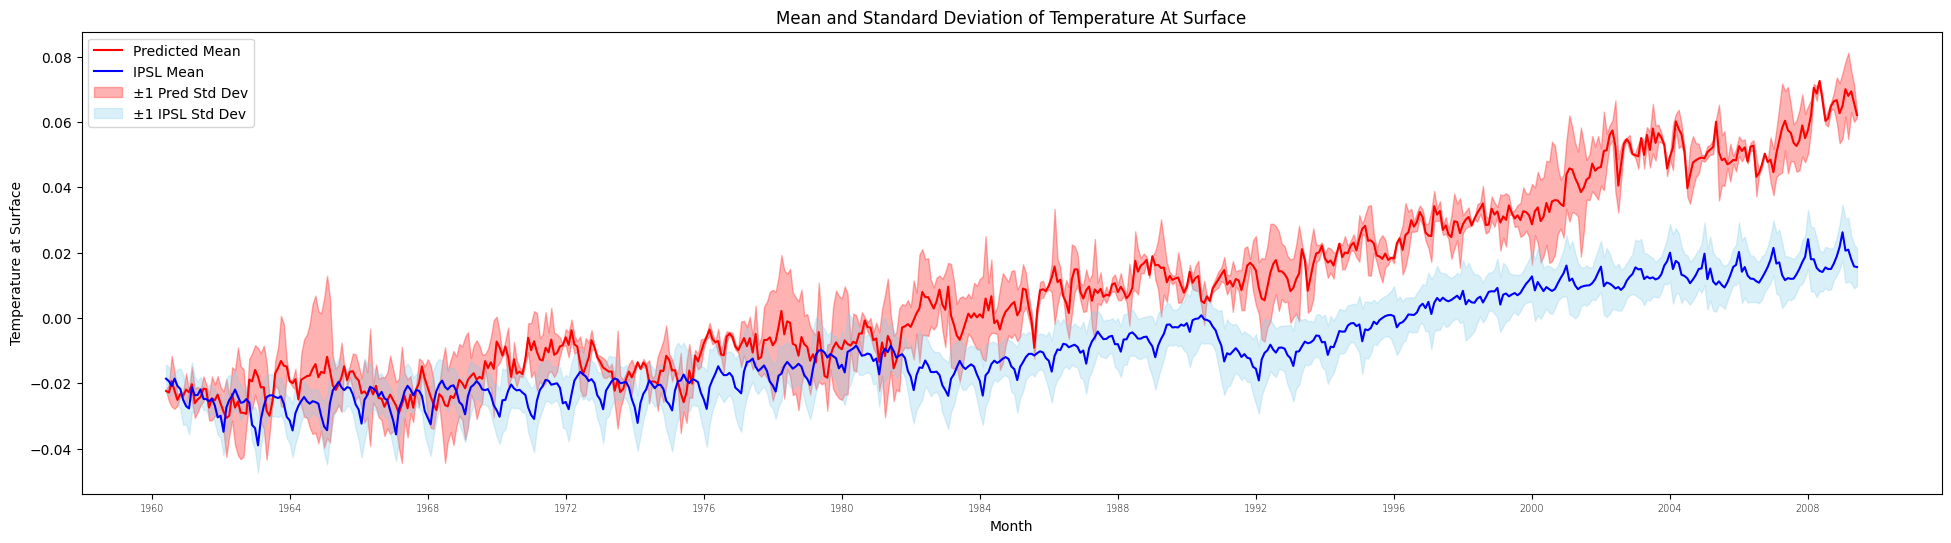

In [5]:
plot_with_fill(means.mean(axis=0)[:-1],stds[:-1],batch_means[1:],batch_stds[1:])

<Axes: title={'center': 'Mean and Standard Deviation of Temperature At Surface'}, xlabel='Month', ylabel='Temperature at Surface'>

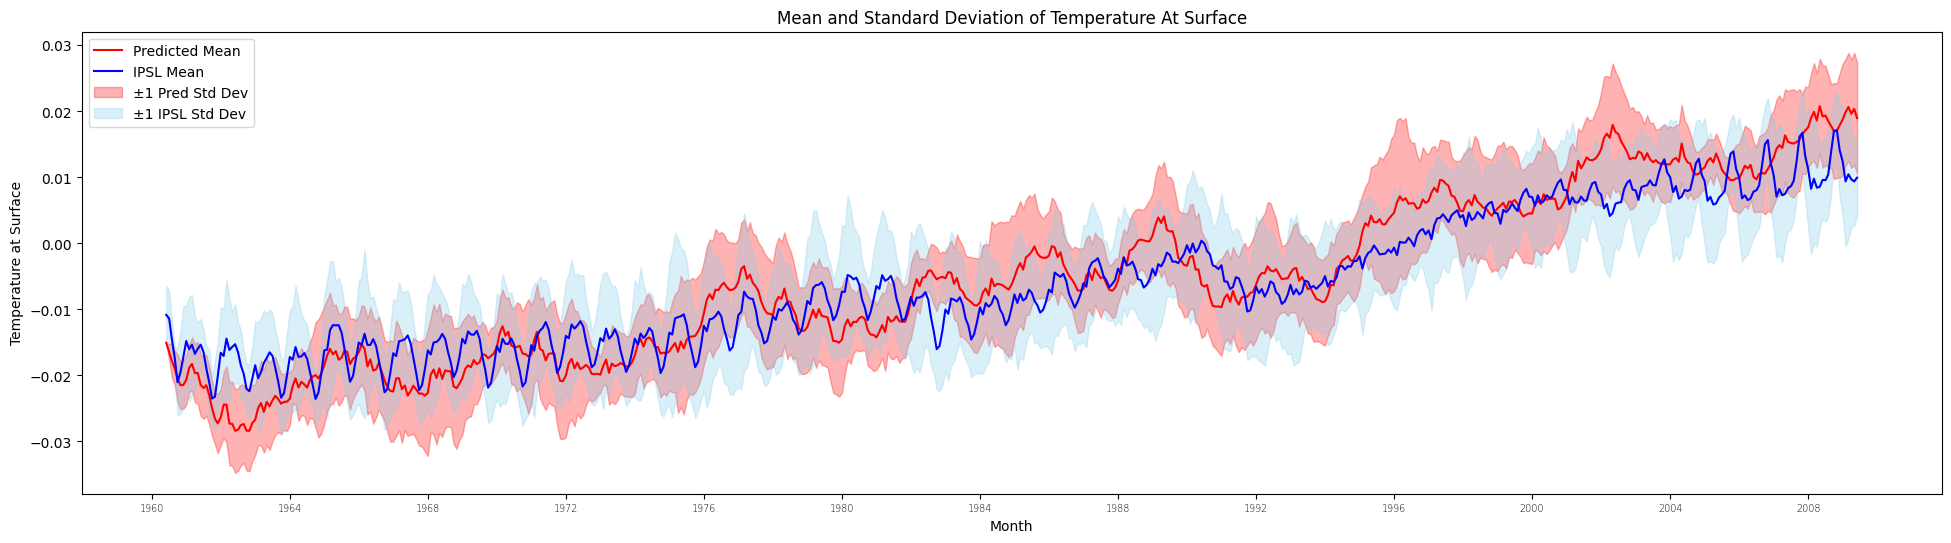

In [11]:
plot_with_fill(means.mean(axis=0)[:-1],stds[:-1],spa.mean(axis=(-1,-2))[1:],batch_stds[1:])

In [6]:
stacked_rollouts.shape

torch.Size([5, 236, 1, 34, 143, 144])

In [ ]:
import numpy as np
z = np.polyfit([x for x in range(len(tas_mean))],tas_mean, deg=1)
p = np.poly1d(z)

#add trendline to plotplt.plot(x, p(x))

plt.plot(p([x for x in range(len(tas_mean))]))
plt.plot(tas_mean,label='tas_mean')
plt.legend()

In [10]:
import torch
spa = torch.load('9_spatial_ensemble_batch_mean.pt')

In [19]:
spa.mean(axis=(-1,-2))

torch.Size([590])

In [42]:
lat = 60
means = stacked_rollouts[:,:,0,0,lat,100].mul(train.lat_coeffs_equi[0,0,:,lat,:]).mean(axis=0)
means = stacked_rollouts[:,:,0,0,lat,100].mean(axis=0)

stds = means.std(axis=(0))
plot_with_fill(
    means[1:],
    [0 for x in range(589)],
#    spa[:,lat,100].mul(train.lat_coeffs_equi[0,0,0,lat,:])[:589],
    spa[:,lat,100][:589],
    [0 for x in range(589)])

In [8]:
from ipsl_dcpp.utils.visualization_utils import make_gif
bias_difference = (stacked_rollouts[:,:,0,0].mean(axis=0) - spa[:,:,:])
# ani = make_gif(bias_difference[None,:,:,:],10,'tas','tas_bias_difference',save=False,denormalized=False)

In [18]:
stacked_rollouts[:,:,0,0].mean()

tensor(-0.0385)

In [20]:
spa[:,:,:].mean()

tensor(277.3627)

In [14]:
lat_coeffs_equi.shape

torch.Size([1, 1, 1, 143, 1])

In [9]:
ani.save(f'tas_bias_difference.gif',fps=1)


MovieWriter ffmpeg unavailable; using Pillow instead.


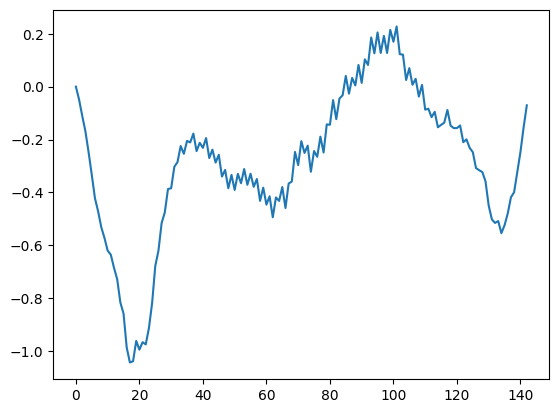

In [9]:
import matplotlib.pyplot as plt
plt.plot(bias_difference.mul(lat_coeffs_equi[0,0]).mean(axis=(0,2)))

In [20]:
import numpy as np
num_train_timesteps = 1000
timesteps = np.linspace(1, num_train_timesteps, num_train_timesteps, dtype=np.float32)[::-1]

In [21]:
timesteps / num_train_timesteps

array([1.   , 0.999, 0.998, 0.997, 0.996, 0.995, 0.994, 0.993, 0.992,
       0.991, 0.99 , 0.989, 0.988, 0.987, 0.986, 0.985, 0.984, 0.983,
       0.982, 0.981, 0.98 , 0.979, 0.978, 0.977, 0.976, 0.975, 0.974,
       0.973, 0.972, 0.971, 0.97 , 0.969, 0.968, 0.967, 0.966, 0.965,
       0.964, 0.963, 0.962, 0.961, 0.96 , 0.959, 0.958, 0.957, 0.956,
       0.955, 0.954, 0.953, 0.952, 0.951, 0.95 , 0.949, 0.948, 0.947,
       0.946, 0.945, 0.944, 0.943, 0.942, 0.941, 0.94 , 0.939, 0.938,
       0.937, 0.936, 0.935, 0.934, 0.933, 0.932, 0.931, 0.93 , 0.929,
       0.928, 0.927, 0.926, 0.925, 0.924, 0.923, 0.922, 0.921, 0.92 ,
       0.919, 0.918, 0.917, 0.916, 0.915, 0.914, 0.913, 0.912, 0.911,
       0.91 , 0.909, 0.908, 0.907, 0.906, 0.905, 0.904, 0.903, 0.902,
       0.901, 0.9  , 0.899, 0.898, 0.897, 0.896, 0.895, 0.894, 0.893,
       0.892, 0.891, 0.89 , 0.889, 0.888, 0.887, 0.886, 0.885, 0.884,
       0.883, 0.882, 0.881, 0.88 , 0.879, 0.878, 0.877, 0.876, 0.875,
       0.874, 0.873,

In [1]:
from ipsl_dcpp.utils.visualization_utils import el_nino_34_index

In [5]:
stacked_rollouts.shape

torch.Size([4, 590, 1, 34, 143, 144])

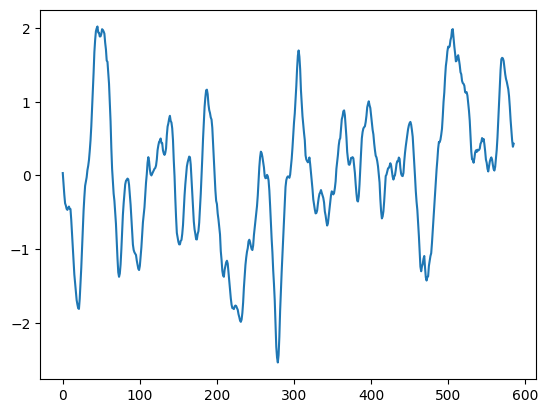

In [7]:
#needs [num_batch_examples (diff IC), num_members, rollout_length,var,lat,lon]
import matplotlib.pyplot as plt
plt.plot(el_nino_34_index(stacked_rollouts[:1,None,:,0]))